# Convolutional Neural Networks

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/ImageNet.png?raw=1)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [1]:
import torch, torchvision

# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [ ]:
from PIL import Image
alcf_image = Image.open("ALCF-Staff.jpg")

FileNotFoundError: [Errno 2] No such file or directory: 'ALCF-Staff.jpg'

In [ ]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

NameError: name 'alcf_image' is not defined

<Figure size 2000x2000 with 0 Axes>

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

![image-2.png](attachment:image-2.png)

![image.png](attachment:image.png)


In [ ]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


NameError: name 'alcf_image' is not defined

## Normalization

![Batch Norm](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/batch_norm.png?raw=1)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/batch_norm_effect.png?raw=1)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


torch.Size([1, 3, 543, 965])


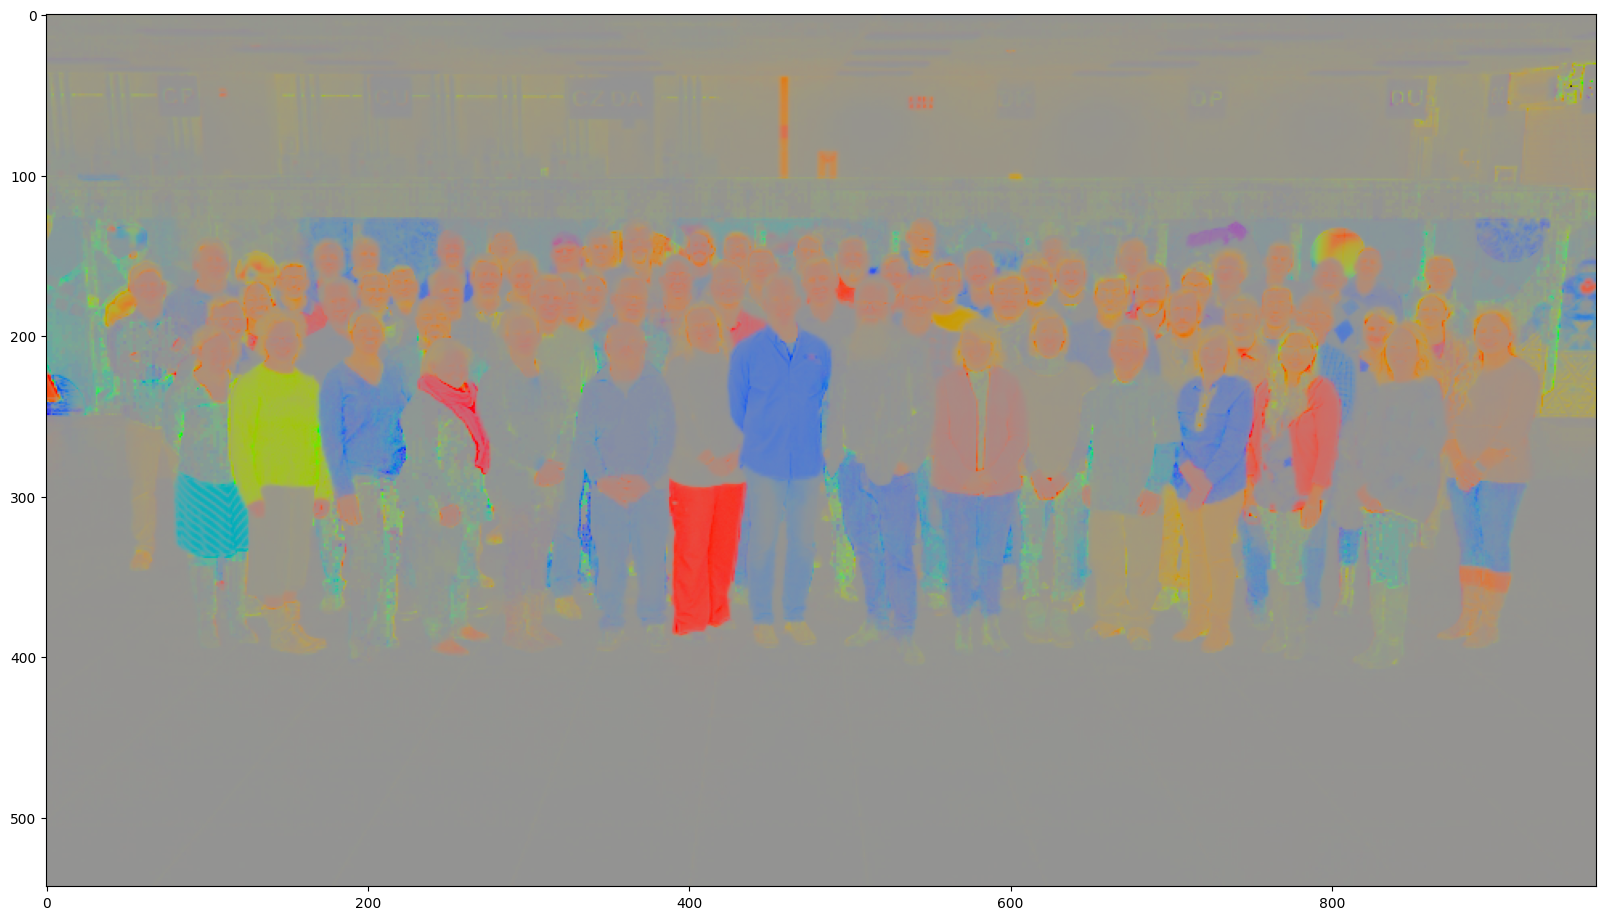

In [ ]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



torch.Size([1, 3, 543, 965])


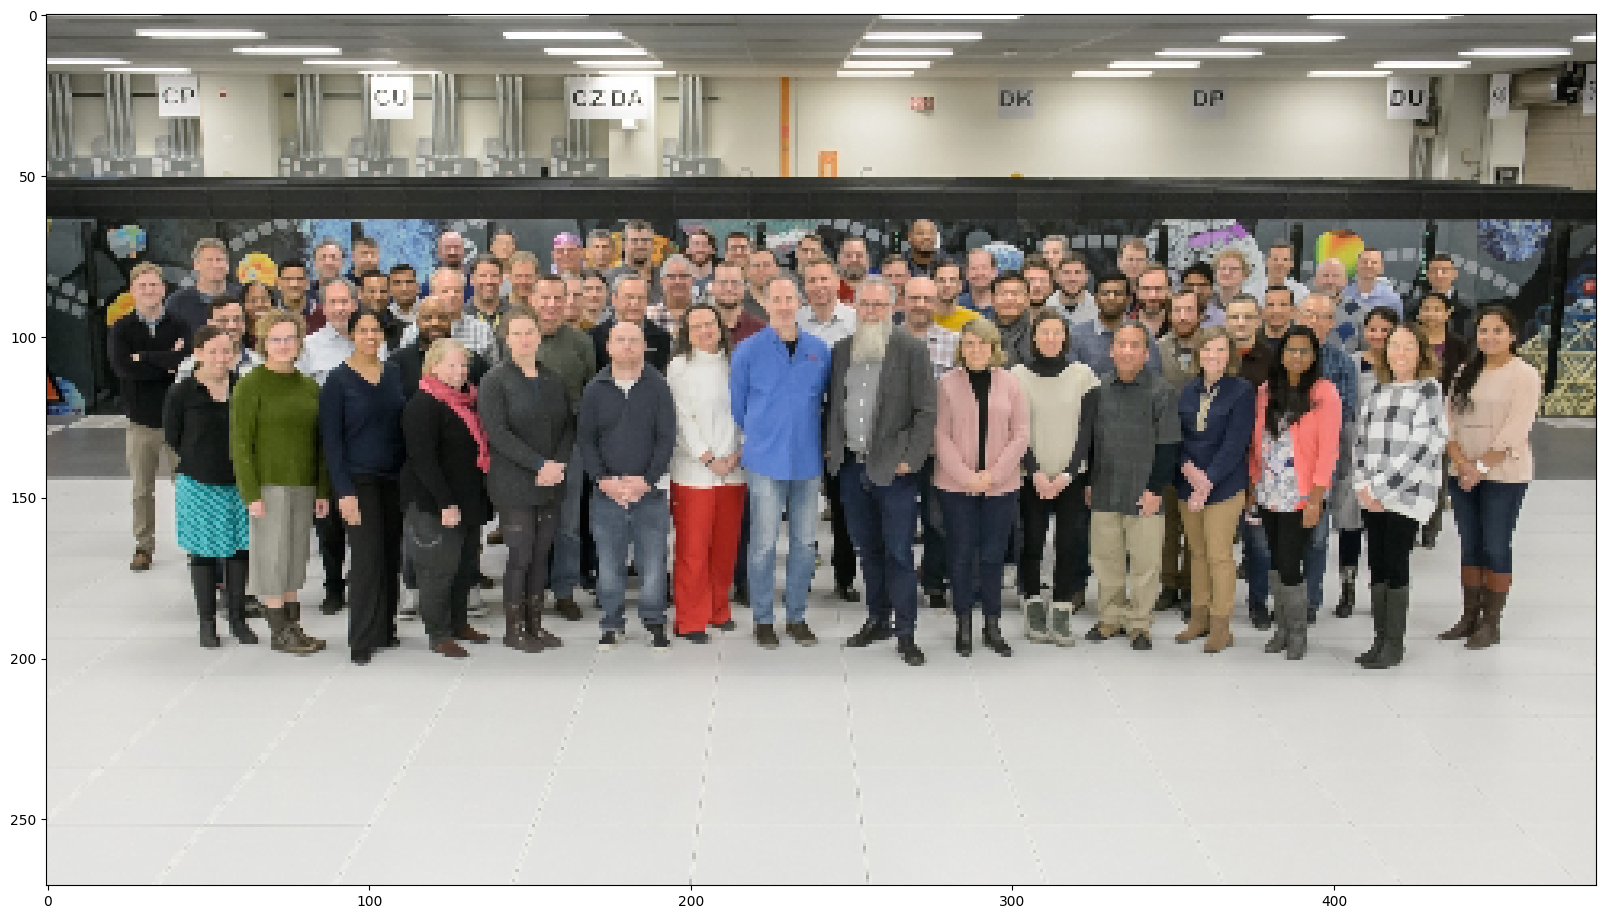

In [ ]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/residual_layer.png?raw=1)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](https://github.com/argonne-lcf/ai-science-training-series/blob/main/03_advanced_neural_networks/resnet_comparison.png?raw=1)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [2]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=True,
    download=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=2)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


100%|██████████| 170498071/170498071 [00:03<00:00, 49038748.48it/s]


Extracting /lus/eagle/projects/datasets/CIFAR-10/cifar-10-python.tar.gz to /lus/eagle/projects/datasets/CIFAR-10/
Files already downloaded and verified


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

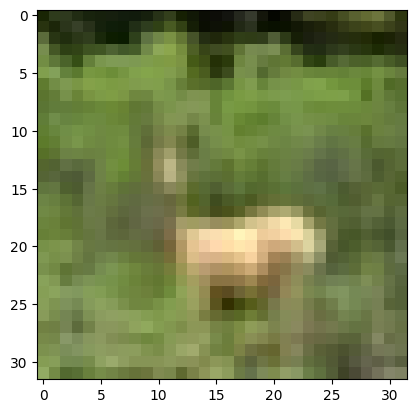

In [4]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [5]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [ ]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [6]:
!pip install torchinfo

In [ ]:
model = Classifier(64, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [128, 256, 32,

In [7]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()

    loss /= num_batches
    correct /= (size*batch_size)

    accuracy = 100*correct
    return accuracy, loss

In [8]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

        progress_bar.update()

In [13]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 0.748, accuracy: 73.864


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 0.887, accuracy: 68.246


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 0.697, accuracy: 75.324


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 0.896, accuracy: 67.959


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 0.557, accuracy: 80.591


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.793, accuracy: 72.765


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 0.510, accuracy: 82.154


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.814, accuracy: 71.608


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.470, accuracy: 83.476


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.797, accuracy: 72.251


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.383, accuracy: 86.641


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.803, accuracy: 73.517


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.309, accuracy: 89.509


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.733, accuracy: 74.842


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.296, accuracy: 89.829


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.807, accuracy: 73.962


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.258, accuracy: 91.104


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.814, accuracy: 74.219


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.213, accuracy: 92.574


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.817, accuracy: 75.000


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.194, accuracy: 93.116


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.821, accuracy: 75.485


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.176, accuracy: 93.740


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.866, accuracy: 75.247


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.213, accuracy: 92.579


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.931, accuracy: 74.080


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.157, accuracy: 94.344


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.895, accuracy: 75.445


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.157, accuracy: 94.471


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.943, accuracy: 75.010


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.132, accuracy: 95.315


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.876, accuracy: 76.276


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.123, accuracy: 95.684


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.918, accuracy: 75.712


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.095, accuracy: 96.725


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.875, accuracy: 76.572


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.109, accuracy: 96.111


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.904, accuracy: 77.453


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.145, accuracy: 94.908


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.009, accuracy: 75.326


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.096, accuracy: 96.605


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.894, accuracy: 76.849


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.094, accuracy: 96.703


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.931, accuracy: 77.008


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.086, accuracy: 96.915


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.924, accuracy: 76.464


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.085, accuracy: 96.900


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.960, accuracy: 76.839


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.109, accuracy: 96.249


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.989, accuracy: 76.187


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.082, accuracy: 97.007


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.917, accuracy: 77.660


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.081, accuracy: 97.077


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.939, accuracy: 77.561


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.082, accuracy: 97.015


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.899, accuracy: 77.799


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.072, accuracy: 97.367


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.934, accuracy: 77.215


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.065, accuracy: 97.609


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.945, accuracy: 77.809


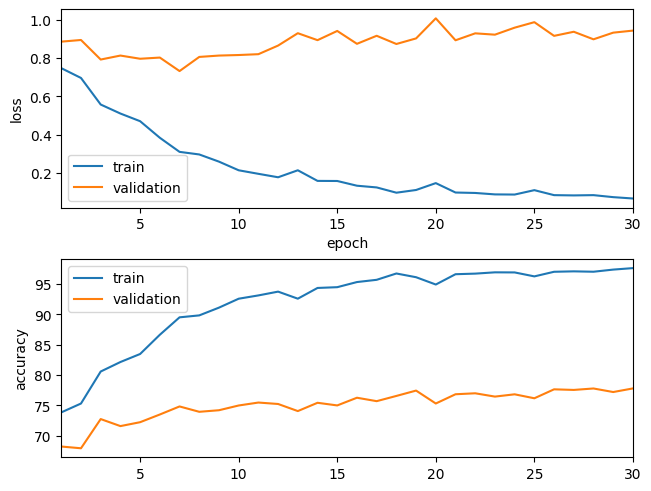

In [ ]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

train_acc = []
train_loss = []
val_acc = []
val_loss = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_acc.append(acc)
        train_loss.append(loss)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        val_acc.append(acc_val)
        val_loss.append(loss_val)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

t = range(1, 31)
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(t, train_loss, label='train')
axs[0].plot(t, val_loss, label='validation')
axs[0].set_xlim(1, 30)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('original results')
#axs[0].grid(True)
axs[0].legend()

axs[1].plot(t, train_acc, label='train')
axs[1].plot(t, val_acc, label='validation')
axs[1].set_xlim(1, 30)
#axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
#axs[1].grid(True)
axs[1].legend()

#plt.legend()
plt.show()


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [ ]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[5,5],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [ ]:
model = Classifier(64, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

ModuleNotFoundError: No module named 'torchinfo'

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.726, accuracy: 35.606


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.714, accuracy: 36.452


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.458, accuracy: 48.036


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.464, accuracy: 47.340


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.199, accuracy: 57.184


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.227, accuracy: 56.102


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 0.990, accuracy: 64.894


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.051, accuracy: 61.768


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.818, accuracy: 71.468


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.913, accuracy: 67.000


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.691, accuracy: 75.559


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.814, accuracy: 71.094


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.651, accuracy: 77.144


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.810, accuracy: 71.440


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.514, accuracy: 82.500


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.689, accuracy: 75.564


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.452, accuracy: 84.515


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.682, accuracy: 76.187


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.398, accuracy: 85.962


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.653, accuracy: 77.255


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.367, accuracy: 87.213


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.667, accuracy: 77.097


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.303, accuracy: 89.721


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.634, accuracy: 78.491


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.247, accuracy: 91.464


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.615, accuracy: 79.163


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.243, accuracy: 91.571


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.658, accuracy: 78.768


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.221, accuracy: 92.245


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.638, accuracy: 79.035


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.182, accuracy: 93.705


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.627, accuracy: 79.984


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.164, accuracy: 94.379


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.641, accuracy: 80.241


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.160, accuracy: 94.554


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.652, accuracy: 80.053


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.171, accuracy: 94.035


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.674, accuracy: 79.312


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.137, accuracy: 95.108


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.640, accuracy: 80.142


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.156, accuracy: 94.496


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.666, accuracy: 79.905


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.133, accuracy: 95.143


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.700, accuracy: 80.103


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.167, accuracy: 94.027


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.753, accuracy: 79.252


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.133, accuracy: 95.243


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.676, accuracy: 80.044


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.124, accuracy: 95.565


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.707, accuracy: 80.162


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.128, accuracy: 95.540


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.706, accuracy: 80.419


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.131, accuracy: 95.285


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.743, accuracy: 79.213


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.120, accuracy: 95.799


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.692, accuracy: 79.945


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.152, accuracy: 94.519


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.762, accuracy: 79.361


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.106, accuracy: 96.296


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.685, accuracy: 80.825


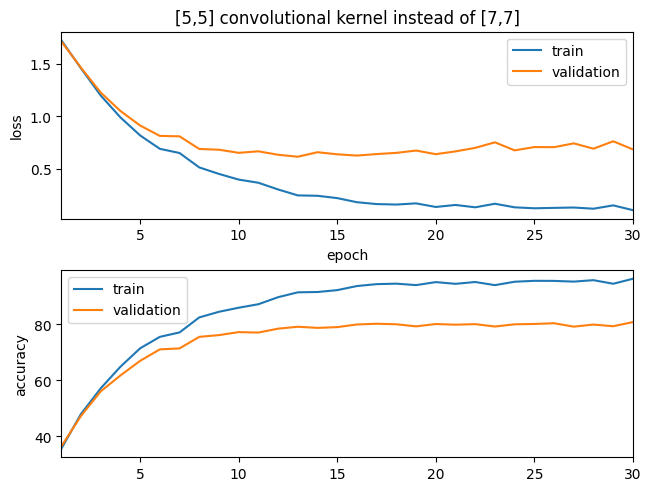

In [ ]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

train_acc = []
train_loss = []
val_acc = []
val_loss = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_acc.append(acc)
        train_loss.append(loss)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        val_acc.append(acc_val)
        val_loss.append(loss_val)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

t = range(1, 31)
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(t, train_loss, label='train')
axs[0].plot(t, val_loss, label='validation')
axs[0].set_xlim(1, 30)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('[5,5] convolutional kernel instead of [7,7]')
#axs[0].grid(True)
axs[0].legend()

axs[1].plot(t, train_acc, label='train')
axs[1].plot(t, val_acc, label='validation')
axs[1].set_xlim(1, 30)
#axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
#axs[1].grid(True)
axs[1].legend()

#plt.legend()
plt.show()

In [ ]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [ ]:
model = Classifier(64, 4, 3)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [128, 256, 32,

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.732, accuracy: 34.847


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.721, accuracy: 34.721


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.403, accuracy: 49.361


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.398, accuracy: 49.011


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.272, accuracy: 54.398


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.295, accuracy: 53.362


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.149, accuracy: 59.223


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.206, accuracy: 55.973


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 1.022, accuracy: 63.778


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.106, accuracy: 59.889


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.921, accuracy: 67.547


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.039, accuracy: 62.619


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.771, accuracy: 72.933


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.930, accuracy: 66.406


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.665, accuracy: 76.805


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.872, accuracy: 69.205


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.584, accuracy: 79.795


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.824, accuracy: 71.104


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.489, accuracy: 83.092


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.795, accuracy: 72.528


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.421, accuracy: 85.715


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.785, accuracy: 73.072


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.383, accuracy: 86.928


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.780, accuracy: 73.101


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.349, accuracy: 87.929


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.825, accuracy: 73.625


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.274, accuracy: 90.745


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.781, accuracy: 74.476


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.252, accuracy: 91.496


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.776, accuracy: 75.455


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.210, accuracy: 92.687


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.807, accuracy: 75.682


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.208, accuracy: 92.707


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.814, accuracy: 75.910


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.180, accuracy: 93.705


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.799, accuracy: 76.226


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.179, accuracy: 93.827


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.811, accuracy: 76.038


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.174, accuracy: 93.962


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.832, accuracy: 75.910


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.149, accuracy: 94.828


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.807, accuracy: 76.503


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.164, accuracy: 94.314


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.845, accuracy: 76.068


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.147, accuracy: 94.811


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.823, accuracy: 76.464


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.141, accuracy: 94.936


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.794, accuracy: 76.859


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.120, accuracy: 95.892


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.840, accuracy: 77.373


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.124, accuracy: 95.637


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.835, accuracy: 76.780


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.139, accuracy: 95.193


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.891, accuracy: 76.562


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.128, accuracy: 95.595


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.863, accuracy: 76.750


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.150, accuracy: 94.821


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.871, accuracy: 75.979


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.121, accuracy: 95.707


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.848, accuracy: 76.622


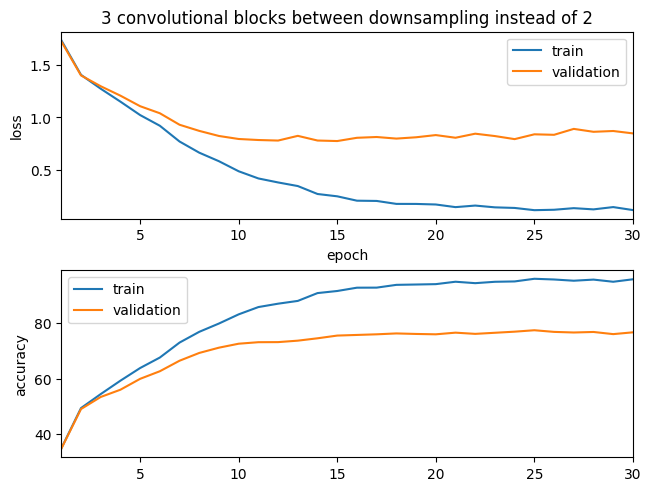

In [ ]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

train_acc = []
train_loss = []
val_acc = []
val_loss = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_acc.append(acc)
        train_loss.append(loss)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        val_acc.append(acc_val)
        val_loss.append(loss_val)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

t = range(1, 31)
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(t, train_loss, label='train')
axs[0].plot(t, val_loss, label='validation')
axs[0].set_xlim(1, 30)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('3 convolutional blocks between downsampling instead of 2')
#axs[0].grid(True)
axs[0].legend()

axs[1].plot(t, train_acc, label='train')
axs[1].plot(t, val_acc, label='validation')
axs[1].set_xlim(1, 30)
#axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
#axs[1].grid(True)
axs[1].legend()

#plt.legend()
plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [10]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )

    def forward(self, inputs):


        return self.downsample(self.norm(inputs))



class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels,
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=2*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=2*in_channels,
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)

        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters

        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters,
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]



        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [11]:
model = Classifier(64, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        8,320
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         8,256
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [128, 128, 32, 3

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.549, accuracy: 43.890


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.546, accuracy: 44.047


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 1.311, accuracy: 52.925


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.322, accuracy: 51.711


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 1.154, accuracy: 58.921


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.202, accuracy: 56.754


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 1.014, accuracy: 64.347


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.089, accuracy: 61.234


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.863, accuracy: 70.180


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.970, accuracy: 65.111


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.729, accuracy: 74.601


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.876, accuracy: 68.493


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.684, accuracy: 76.031


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.859, accuracy: 69.413


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.557, accuracy: 80.506


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.772, accuracy: 72.340


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.478, accuracy: 83.501


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.729, accuracy: 73.972


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.420, accuracy: 85.456


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.717, accuracy: 74.733


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.356, accuracy: 87.822


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.693, accuracy: 75.801


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.290, accuracy: 89.931


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.666, accuracy: 77.294


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.290, accuracy: 89.652


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.705, accuracy: 75.900


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.255, accuracy: 91.461


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.706, accuracy: 76.958


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.239, accuracy: 91.731


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.746, accuracy: 76.384


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.209, accuracy: 92.662


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.741, accuracy: 77.215


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.194, accuracy: 92.971


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.754, accuracy: 77.631


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.167, accuracy: 94.137


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.736, accuracy: 78.610


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.154, accuracy: 94.559


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.734, accuracy: 77.957


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.145, accuracy: 94.768


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.768, accuracy: 77.967


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.158, accuracy: 94.521


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.829, accuracy: 77.334


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.126, accuracy: 95.485


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.757, accuracy: 78.491


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.119, accuracy: 95.817


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.787, accuracy: 78.540


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.123, accuracy: 95.727


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.817, accuracy: 78.372


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.107, accuracy: 96.136


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.808, accuracy: 78.461


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.093, accuracy: 96.620


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.769, accuracy: 79.549


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.111, accuracy: 96.024


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.823, accuracy: 78.540


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.092, accuracy: 96.640


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.822, accuracy: 78.956


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.094, accuracy: 96.588


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.812, accuracy: 79.628


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.112, accuracy: 96.001


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.874, accuracy: 78.461


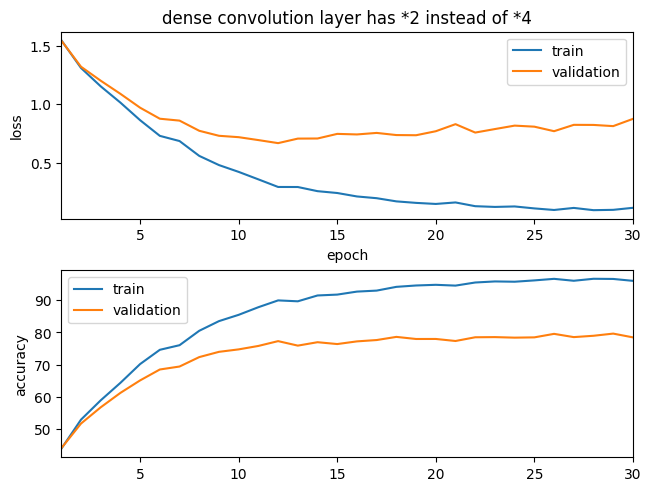

In [14]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

train_acc = []
train_loss = []
val_acc = []
val_loss = []

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)

    # checking on the training loss and accuracy once per epoch

    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_acc.append(acc)
        train_loss.append(loss)
        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        val_acc.append(acc_val)
        val_loss.append(loss_val)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

t = range(1, 31)
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(t, train_loss, label='train')
axs[0].plot(t, val_loss, label='validation')
axs[0].set_xlim(1, 30)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('dense convolution layer has *2 instead of *4')
#axs[0].grid(True)
axs[0].legend()

axs[1].plot(t, train_acc, label='train')
axs[1].plot(t, val_acc, label='validation')
axs[1].set_xlim(1, 30)
#axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
#axs[1].grid(True)
axs[1].legend()

#plt.legend()
plt.show()

I tried changing three things: the size of the convolutional kernel, the number of convolutional blocks, and the width of the dense layer in the middle of the convolutional block, after applying the convolution. I found that using a [5,5] convolutional kernel instead of [7,7] or a dense layer with twice the size of the surrounding layer instead of four times both improved the accuracy and loss, while increasing the number of convolutional blocks decreased the accuracy and loss, all of which may be seen from the plots. This is the opposite of what I would expect, since decreasing the number of parameters should lead to worse results, while increasing the number of parameters should increase expressivity and lead to better results. Perhaps these results are related to the fact that the original model is already overfitting.